In [ ]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Input, Conv1D, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout, Bidirectional, GRU, Attention, Activation, Dot, concatenate
from keras.models import Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [ ]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [ ]:
bird_labels = metadata['species']
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

In [ ]:
# Function to read audio file
def read_file(path):
    y, _ = librosa.load(path, sr=22050)  # Set the sample rate to ensure consistency
    return y

# Function to convert to dB scale
def spec_to_db(y):
    y_db = librosa.power_to_db(y, ref=np.max)
    #y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

# Map function that returns spectrograms
def map_function(path_tensor, label):
    # Load audio file
    y = tf.numpy_function(read_file, inp=[path_tensor], Tout=tf.float32)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))

    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=tf.shape(spectrogram)[-1],
        sample_rate=22050,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0)
    mel_spectrogram = tf.matmul(spectrogram, mel_weights)

    # Convert to dB scale
    #log_mel_spectrogram = tf.numpy_function(spec_to_db, inp=[mel_spectrogram], Tout=tf.float32)

    #spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    #spectrogram_db = spectrogram_db/80+1

    return mel_spectrogram, label


def make_dataset(bird_labels, file_paths, shuffle):
    bird_labels = tf.convert_to_tensor(bird_labels, dtype = tf.int32)
    file_paths = tf.convert_to_tensor(file_paths, dtype = tf.string)

    bird_labels = tf.data.Dataset.from_tensor_slices(bird_labels)
    file_paths = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = tf.data.Dataset.zip( file_paths, bird_labels)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 64, num_parallel_calls = tf.data.AUTOTUNE, drop_remainder = True)

    return dataset

In [ ]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, bird_labels, test_size=0.20, random_state=42)

dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

for batch in dataset_train.take(1):
    input_data_shape = batch[0].shape
print("Shape of input data in training dataset:", input_data_shape)

Shape of input data in training dataset: (64, 1026, 128)


In [ ]:
def create_model():
    inputs = Input(shape=(1026, 128), name='0_Input_shape')

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name='2_SpatialDropout1D')(x)

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='3_Conv1d', kernel_regularizer=l2(0.01))(x)
    x = SpatialDropout1D(0.17, name='4_SpatialDropout1D')(x)

    x = Conv1D(64, 8, 2, activation='relu', padding='same', name='5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name='6_SpatialDropout1D')(x)

    x = Bidirectional(GRU(64, return_sequences=True, name='GRU_1'), merge_mode='concat')(x)
    x = Attention()([x, x])

    x = GlobalAveragePooling1D(name='9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5, name='11_Dropout')(x)

    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name='Bird_audio_classification_model')

    return model

In [ ]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 0_Input_shape (InputLayer)  [(None, 1026, 128)]          0         []                            
                                                                                                  
 1_Conv1D (Conv1D)           (None, 513, 64)              65600     ['0_Input_shape[0][0]']       
                                                                                                  
 2_SpatialDropout1D (Spatia  (None, 513, 64)              0         ['1_Conv1D[0][0]']            
 lDropout1D)                                                                                      
                                                                                                  
 3_Conv1d (Conv1D)           (None, 257, 64)              32832     

In [ ]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

In [ ]:
# Creating callbacks
logdir = 'tb_logs_1/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint_1/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
training = model.fit(dataset_train, validation_data = dataset_test, epochs=120,
                    callbacks=[tensorboard_callback,model_checkpoint_callback])


Epoch 1/120
67/67 [==============================] - 29s 363ms/step - loss: 3.0259 - sparse_categorical_accuracy: 0.5009 - val_loss: 2.0780 - val_sparse_categorical_accuracy: 0.6660
Epoch 2/120
67/67 [==============================] - 25s 371ms/step - loss: 1.7038 - sparse_categorical_accuracy: 0.6681 - val_loss: 1.2762 - val_sparse_categorical_accuracy: 0.7520
Epoch 3/120
67/67 [==============================] - 24s 359ms/step - loss: 1.1410 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.7998
Epoch 4/120
67/67 [==============================] - 27s 400ms/step - loss: 0.8829 - sparse_categorical_accuracy: 0.7838 - val_loss: 0.7765 - val_sparse_categorical_accuracy: 0.8066
Epoch 5/120
67/67 [==============================] - 24s 364ms/step - loss: 0.7158 - sparse_categorical_accuracy: 0.8312 - val_loss: 0.6155 - val_sparse_categorical_accuracy: 0.8477
Epoch 6/120
67/67 [==============================] - 25s 368ms/step - loss: 0.6235 - spars

# Test Loss Curve

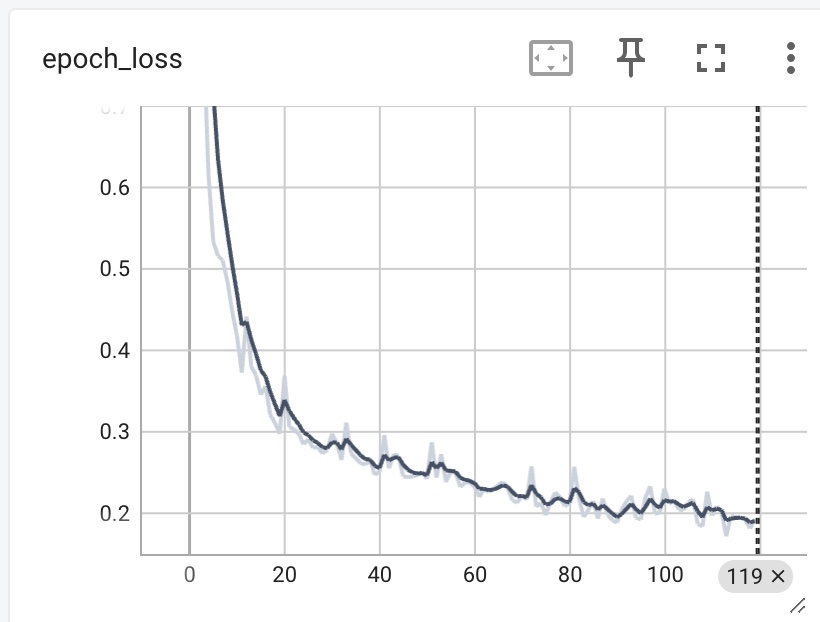